</span>
</center></b>
</span><br>
<p>
<i><center>
<span style="font-size: 20pt; line-height: 1.2">
Homework 3b: MongoDB and Neo4j<br>
    Common Tasks
</span>
</center></i><br><br>

# Overview

- There are three parts to HW 3:
    - ```3a```: Written questions
    - ```3b:``` A set of common practical tasks.
    - ```3c:``` Programming and Non-Programming track specific tasks.
    
    
- This notebook explains part ```3b,``` which is a prerequisite for part ```3c.```


- In this task, you will process files to load data into both Neo4j and MongoDB in the cloud.


- This builds on the previous notebook's setup tasks that we published.

# Data Loading

## Read Files

- The project data a data directory. The directory contains JSON data.


- The next few cells read the JSON information and load into Python lists.

In [38]:
import json

In [39]:
def load_json(fn):
    result = None
    with open(fn, "r") as in_file:
        result = json.load(in_file)
    return result
        

In [40]:
characters = load_json("./data/characters.json")

In [41]:
characters[0:2]

[{'characterName': 'Addam Marbrand',
  'characterLink': '/character/ch0305333/',
  'actorName': 'B.J. Hogg',
  'actorLink': '/name/nm0389698/'},
 {'characterName': 'Aegon Targaryen',
  'houseName': 'Targaryen',
  'royal': True,
  'parents': ['Elia Martell', 'Rhaegar Targaryen'],
  'siblings': ['Rhaenys Targaryen', 'Jon Snow'],
  'killedBy': ['Gregor Clegane']}]

In [42]:
episodes = load_json("./data/episodes.json")

In [43]:
episodes[0:1]

[{'seasonNum': 1,
  'episodeNum': 1,
  'episodeTitle': 'Winter Is Coming',
  'episodeLink': '/title/tt1480055/',
  'episodeAirDate': '2011-04-17',
  'episodeDescription': "Jon Arryn, the Hand of the King, is dead. King Robert Baratheon plans to ask his oldest friend, Eddard Stark, to take Jon's place. Across the sea, Viserys Targaryen plans to wed his sister to a nomadic warlord in exchange for an army.",
  'openingSequenceLocations': ["King's Landing",
   'Winterfell',
   'The Wall',
   'Pentos'],
  'scenes': [{'sceneStart': '0:00:40',
    'sceneEnd': '0:01:45',
    'location': 'The Wall',
    'subLocation': 'Castle Black',
    'characters': [{'name': 'Gared'},
     {'name': 'Waymar Royce'},
     {'name': 'Will'}]},
   {'sceneStart': '0:01:45',
    'sceneEnd': '0:03:24',
    'location': 'North of the Wall',
    'subLocation': 'The Haunted Forest',
    'characters': [{'name': 'Gared'},
     {'name': 'Waymar Royce'},
     {'name': 'Will'}]},
   {'sceneStart': '0:03:24',
    'sceneEnd': 

In [44]:
locations = load_json("./data/locations.json")

In [45]:
locations[0:2]

[{'location': 'North of the Wall',
  'subLocation': ['The Lands of Always Winter',
   'Cave Outside Wildling Camp',
   'Wildling Camp',
   'Frostfang Mountains',
   'The Three-Eyed Raven',
   'Outside the Three-Eyed Raven',
   'Fist of the First Men',
   'Wildlings March South',
   'Nightswatch March South',
   'Hardhome',
   "Craster's Keep",
   'The Haunted Forest',
   'South to the Wall',
   'Destroyed Cabin',
   'Near Nightfort',
   'The Wall']},
 {'location': 'The Wall',
  'subLocation': ['Nightfort',
   'Eastwatch',
   'Top of the Wall',
   'Castle Black',
   'Outside Castle Black',
   "Mole's Town",
   'The Gift']}]

In [46]:
characters_groups = load_json("./data/characters-groups.json")

In [47]:
characters_groups[0:1]

[{'name': 'Stark',
  'characters': ['Arya Stark',
   'Benjen Stark',
   'Bran Stark',
   'Catelyn Stark',
   'Eddard Stark',
   'Ghost',
   'Grey Wind',
   'Jon Snow',
   'Lady',
   'Nymeria',
   'Rickon Stark',
   'Robb Stark',
   'Sansa Stark',
   'Shaggydog',
   'Summer']}]

## Assignment 1: Load MongoDB

### Load Information

- You must load the data into collections in MongoDB.


- The following code uses the helper files from setup to get a connection to MongoDB.

In [48]:
import got_mongo

In [49]:
client = got_mongo.get_client()

- In the following cells, write Python code that loads the information into:
    - Database: ```GoT```
    - Collections: ```characters, episodes, locations, groups.```

- Put your code to load in the cells below. Later, there are some tests.

In [50]:
# Load characters
# Check connection
client.server_info()

# load characters
characters_collection = client["got"]["characters"]
characters_collection.insert_many(characters)



In [51]:
# Load episodes
episodes_collection = client["got"]["episodes"]
episodes_collection.insert_many(episodes)


In [52]:
# Load locations
locations_collection = client["got"]["locations"]
locations_collection.insert_many(locations)


In [53]:
# Load character groups.
characters_groups_collection = client["got"]["characters_groups"]
characters_groups_collection.insert_many(characters_groups)


### Interesting Tests

- If you have loaded the data character, the following queries should produce interesting results.

#### Characters in Episodes

In [54]:
client = got_mongo.get_client()

In [55]:
def get_characters_per_episode(seasonNum, episodeNum):
    client = got_mongo.get_client()
    result = client['GoT']['episodes'].aggregate([
        {
            '$match': {
                'episodeNum': seasonNum, 
                'seasonNum': episodeNum
            }
        }, {
            '$project': {
                'characters': '$scenes.characters'
            }
        }, {
            '$unwind': {
                'path': '$characters', 
                'preserveNullAndEmptyArrays': False
            }
        }, {
            '$unwind': {
                'path': '$characters', 
                'preserveNullAndEmptyArrays': False
            }
        }, {
            '$project': {
                'characterName': '$characters.name', 
                '_id': 0
            }
        }
    ])
    return result

In [56]:
result = get_characters_per_episode(2, 1)
result = list(result)

In [57]:
result[0:2]

[]

In [58]:
result = [l['characterName'] for l in result]
result = set(result)

In [59]:
result

set()

#### Find All the Actors who Played a Character in a Group

In [60]:
def get_actor_for_group(group_name):
    client = got_mongo.get_client()

    result = client['GoT']['groups'].aggregate([
        {
            '$match': {
                "name": group_name
            }
        },
        {
            '$unwind': {
                'path': '$characters', 
                'preserveNullAndEmptyArrays': True
            }
        }, {
            '$project': {
                'groupName': '$name', 
                'characterName': '$characters'
            }
        }, {
            '$lookup': {
                'from': 'characters', 
                'localField': 'characterName', 
                'foreignField': 'characterName', 
                'as': 'character'
            }
        }, {
            '$unwind': {
                'path': '$character'
            }
        }, {
            '$project': {
                'characterName': 1, 
                'groupName': 1, 
                'actorName': '$character.actorName', 
                'actorLink': {
                    '$concat': [
                        'https://www.imdb.com', '$character.actorLink'
                    ]
                }
            }
        }
    ])
    return result

In [61]:
nights_watch_actors = get_actor_for_group("Night's Watch")

In [62]:
result = list(nights_watch_actors)
result

[]

## Assignment 2: Load Neo4j

### Load Data

- You loaded information about characters and groups into MongoDB.


- You also have to data loaded into a Python data structure from prior steps in this notebook.

In [63]:
characters_groups

[{'name': 'Stark',
  'characters': ['Arya Stark',
   'Benjen Stark',
   'Bran Stark',
   'Catelyn Stark',
   'Eddard Stark',
   'Ghost',
   'Grey Wind',
   'Jon Snow',
   'Lady',
   'Nymeria',
   'Rickon Stark',
   'Robb Stark',
   'Sansa Stark',
   'Shaggydog',
   'Summer'],
  '_id': ObjectId('625fb314d2eb3587a9a271c9')},
 {'name': 'Targaryen',
  'characters': ['Daenerys Targaryen',
   'Drogon',
   'Rhaegal',
   'Viserion',
   'Viserys Targaryen'],
  '_id': ObjectId('625fb314d2eb3587a9a271ca')},
 {'name': 'Baratheon',
  'characters': ['Joffrey Baratheon',
   'Myrcella Baratheon',
   'Renly Baratheon',
   'Robert Baratheon',
   'Selyse Baratheon',
   'Shireen Baratheon',
   'Stannis Baratheon',
   'Tommen Baratheon',
   'Gendry'],
  '_id': ObjectId('625fb314d2eb3587a9a271cb')},
 {'name': 'Lannister',
  'characters': ['Cersei Lannister',
   'Jaime Lannister',
   'Kevan Lannister',
   'Lancel Lannister',
   'Tyrion Lannister',
   'Tywin Lannister'],
  '_id': ObjectId('625fb314d2eb3587a9a

- Your task is to:
    - Create a node in your Neo4j database for each group.
    - Create a node in your Neo4j database for each character in a group. If a character is in multiple groups, you should only create the node once.
    - Create a relationship ```MEMBER_OF``` from the character node to the group node for each member in the group.
    
    
- The code below retests your ability to connect to Neo4j.

In [64]:
import got_test_neo

In [65]:
g = got_test_neo.get_graph()

In [66]:
q = "match (p:Person) where p.name=$name return p"
res = g.run_q(q, {"name": "Tom Hanks"})
print(type(res))
for r in res:
    print(type(r))
    print(r)
    print("Labels = ", r['p'].labels)
    print("Properties = ", dict(r['p']))

<class 'py2neo.cypher.Cursor'>


- Use the cells below to load Neo4j.


- In the next section, we will run some tests that will help you understand if you created the information correctly.

In [67]:
# Put your loading code here.
# Looking at the code in got_test_neo.py may help you.
#

q = "match (p:Person) where p.name=$name return p"
for r in g.run_q(q, {"name": "Tom Hanks"}):
    print(type(r))
    print(r)
    for k, v in r.items():
        print(k, v)
        print("Labels = ", v.labels)
        print("Properties = ", dict(v))

### Test Load

- Running the following query in the query explorer for Neo4j should produce the following.

```
match (s:GoT_Character {character_name: "Jon Snow"})-[r:MEMBER_OF]->(g)
    return s,r,g
```

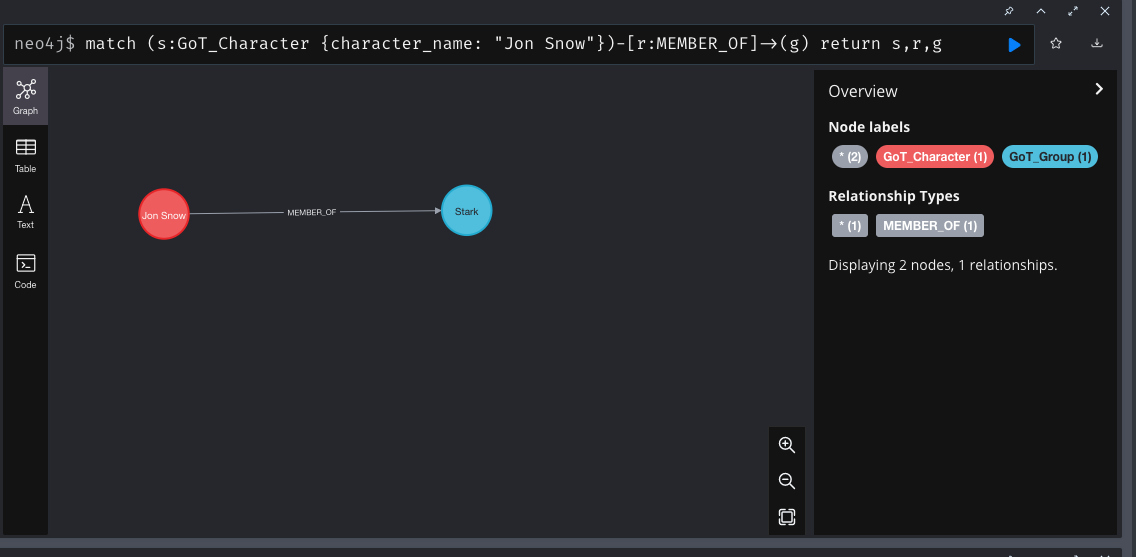

- You can test this using ... ...

In [68]:
cypher_q = """
    match
        (c:GoT_Character {character_name: 'Jon Snow'})-[r:MEMBER_OF]->(g)
    return c,r,g
"""
res = g.run_q(cypher_q, None)

In [69]:
for r in res:
    print(r[0])
    print(r[1])
    print(r[2])

- The following query and code will produce a data frame of groups and characters

In [70]:
cypher_q = """
    match
        (c:GoT_Character)-[r:MEMBER_OF]->(g)
    return c.character_name, g.group_name
"""
res = g.run_q(cypher_q, None)

In [71]:
import pandas as pd

In [72]:
df = pd.DataFrame(res)

In [73]:
df.columns = ['character_name', 'group_name']
df

ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements